In [29]:
import pandas as pd
import re
import tldextract
from urllib.parse import urlparse
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report

In [30]:
df= pd.read_csv("new_data_urls.csv")
df.head()


,url,status
0,0000111servicehelpdesk.godaddysites.com,0
1,000011accesswebform.godaddysites.com,0
2,00003.online,0
3,0009servicedeskowa.godaddysites.com,0
4,000n38p.wcomhost.com,0


In [31]:
print(df["status"].value_counts())
print("Total rows in dataset:", len(df))

status
1    427028
0    394982
Name: count, dtype: int64
Total rows in dataset: 822010


In [32]:
def has_ip(url):
    """Check if URL contains an IP address."""
    try:
        ipaddress.ip_address(urlparse(url).netloc)
        return 1
    except ValueError:
        return 0

In [33]:
def count_special_chars(url):
    """Count special characters in URL."""
    return len(re.findall(r'[./?\-_@=]', url))

In [34]:
def extract_features(df):
    """Extract necessary features from URLs."""
    df['url_length'] = df['url'].apply(len)
    df['num_special_chars'] = df['url'].apply(count_special_chars)
    df['num_digits'] = df['url'].apply(lambda x: sum(c.isdigit() for c in x))
    df['num_letters'] = df['url'].apply(lambda x: sum(c.isalpha() for c in x))
    df['num_subdomains'] = df['url'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')))
    df['has_ip'] = df['url'].apply(has_ip)
    df['uses_https'] = df['url'].apply(lambda x: 1 if urlparse(x).scheme == 'https' else 0)
    df['tld'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)
    
    # Keep only the top 10 most frequent TLDs, others will be grouped as 'other'
    top_tlds = df['tld'].value_counts().nlargest(10).index
    df['tld'] = df['tld'].apply(lambda x: x if x in top_tlds else 'other')
    df = pd.get_dummies(df, columns=['tld'], drop_first=True)
    
    return df






In [35]:
df_features = extract_features(df)

In [36]:
print(df_features.columns)

Index(['url', 'status', 'url_length', 'num_special_chars', 'num_digits',
       'num_letters', 'num_subdomains', 'has_ip', 'uses_https', 'tld_ca',
       'tld_cn', 'tld_co.uk', 'tld_com', 'tld_edu', 'tld_net', 'tld_org',
       'tld_other', 'tld_ru', 'tld_top'],
      dtype='object')


In [37]:
# Drop the original URL column if it exists
if 'url' in df_features.columns:
    df_features = df_features.drop(columns=['url'])

In [38]:
# Split dataset into train and test sets
X = df_features.drop(columns=['status'])  # Features
y = df_features['status']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Handle missing values (if any)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [40]:
# Feature selection: Keep only the 15 best features
selector = SelectKBest(score_func=f_classif, k=15)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [41]:
# Train Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

In [42]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [43]:
# Save processed dataset
df_features.to_csv("processed_data.csv", index=False)


In [44]:

# Display results
print("Feature extraction and selection complete. Processed dataset saved.")
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Feature extraction and selection complete. Processed dataset saved.
Model Accuracy: 0.8565
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84     79122
           1       0.83      0.91      0.87     85280

    accuracy                           0.86    164402
   macro avg       0.86      0.85      0.86    164402
weighted avg       0.86      0.86      0.86    164402



In [50]:
# Extract selected feature names
selected_feature_names = X.columns[selector.get_support()]

# Print feature importances with names
for feature, importance in zip(selected_feature_names, clf.feature_importances_):
    print(f"{feature}: {importance:.4f}")


num_special_chars: 0.1972
num_digits: 0.1401
num_letters: 0.1756
num_subdomains: 0.0565
has_ip: 0.0030
uses_https: 0.1432
tld_ca: 0.0087
tld_cn: 0.0304
tld_co.uk: 0.0031
tld_com: 0.0703
tld_edu: 0.0156
tld_org: 0.0213
tld_other: 0.1126
tld_ru: 0.0113
tld_top: 0.0113


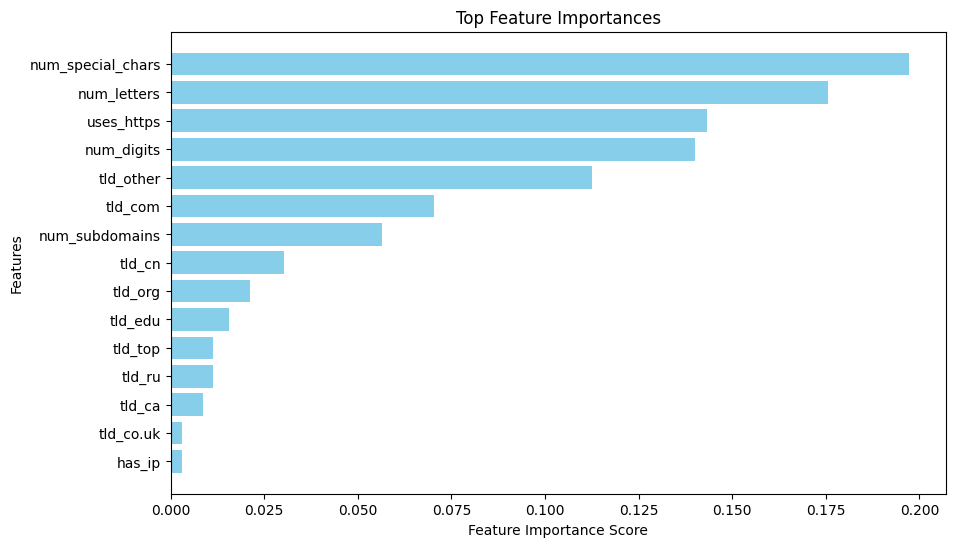

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Sort feature importances in descending order
sorted_idx = np.argsort(clf.feature_importances_)[::-1]
sorted_features = np.array(selected_feature_names)[sorted_idx]
sorted_importances = clf.feature_importances_[sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [47]:
# Function to predict phishing for multiple URLs
def predict_urls(url_list):
    """Predict whether the given URLs are phishing or legitimate."""
    test_df = pd.DataFrame({'url': url_list})
    test_features = extract_features(test_df)
    test_features = test_features.reindex(columns=X.columns, fill_value=0)  # Align with training features
    test_features = selector.transform(test_features)  # Apply feature selection
    predictions = clf.predict(test_features)
    return dict(zip(url_list, predictions))

In [48]:
# Example usage
urls_to_test = [
    "https://www.tesla.com",
    "https://www.reddit.com",
    "https://www.adobe.com",
    "http://secure-update-paypal.com",
    "http://microsoft-verification-login.com",
    "http://amazon-account-security-check.com",
    "http://instagram-login-authenticate.com"
]

In [49]:
results = predict_urls(urls_to_test)
print("Prediction Results:")
for url, pred in results.items():
    print(f"{url}: {'Phishing' if pred == 1 else 'Legitimate'}")

Prediction Results:
https://www.tesla.com: Legitimate
https://www.reddit.com: Legitimate
https://www.adobe.com: Legitimate
http://secure-update-paypal.com: Phishing
http://microsoft-verification-login.com: Phishing
http://amazon-account-security-check.com: Phishing
http://instagram-login-authenticate.com: Phishing


In [52]:
import joblib

# Save the trained model
joblib.dump(clf, "phishing_model.pkl")

# Save the feature selector (so you can use the same features later)
joblib.dump(selector, "feature_selector.pkl")

# Save the column names used in training (needed for new data processing)
joblib.dump(X.columns, "feature_columns.pkl")

print("Model saved successfully!")

Model saved successfully!
